In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-prediction-dataset/test_loan.csv
/kaggle/input/loan-prediction-dataset/train_loan.csv
/kaggle/input/crimedataset/2022-10-leicestershire-street.csv
/kaggle/input/crimedataset/2022-06-kent-street.csv
/kaggle/input/crimedataset/2022-11-derbyshire-street.csv
/kaggle/input/crimedataset/2022-07-kent-street.csv
/kaggle/input/crimedataset/2022-02-leicestershire-street.csv
/kaggle/input/crimedataset/2022-10-derbyshire-street.csv
/kaggle/input/crimedataset/2022-03-kent-street.csv
/kaggle/input/crimedataset/2022-07-leicestershire-street.csv
/kaggle/input/crimedataset/2022-02-kent-street.csv
/kaggle/input/crimedataset/2022-09-kent-street.csv
/kaggle/input/crimedataset/2022-02-derbyshire-street.csv
/kaggle/input/crimedataset/2022-01-derbyshire-street.csv
/kaggle/input/crimedataset/2022-08-derbyshire-street.csv
/kaggle/input/crimedataset/2022-11-leicestershire-street.csv
/kaggle/input/crimedataset/2022-06-derbyshire-street.csv
/kaggle/input/crimedataset/2022-11-kent-street.csv
/ka

In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840629 sha256=872fc508eaa244966fd8a7d9a5cb19535e98ef2a5f38438e2cdf091e894d1bae
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Spark session
spark = SparkSession.builder.appName("CrimeDataAnalysis").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/08 16:38:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
import os

data_dir = '/kaggle/input/crimedataset'
dataframes = []

for filename in os.listdir(data_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(data_dir, filename)
        df = spark.read.csv(file_path, header=True, inferSchema=True)
        dataframes.append(df)

# Combine all monthly data into one DataFrame
crime_data = dataframes[0]
for df in dataframes[1:]:
    crime_data = crime_data.union(df)


In [5]:
crime_data.printSchema()
crime_data.show(5)

root
 |-- Crime ID: string (nullable = true)
 |-- Month: timestamp (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)

+--------------------+-------------------+--------------------+--------------------+---------+---------+--------------------+---------+----------+--------------------+---------------------+-------+
|            Crime ID|              Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code| LSOA name|          Crime type|Last outcome category|Context|
+--------------------+-------------------+--------------------+--------------------+---------+

In [6]:
df_crime = (crime_data
            .withColumnRenamed('Crime ID', 'Crime_ID')
            .withColumnRenamed('Reported by', 'Reported_by')
            .withColumnRenamed('Falls within', 'Falls_within')
            .withColumnRenamed('LSOA code', 'LSOA_code')
            .withColumnRenamed('LSOA name', 'LSOA_name')
            .withColumnRenamed('Crime type', 'Crime_type'))

# Verify the renaming
df_crime.printSchema()
df_crime.show(5)

root
 |-- Crime_ID: string (nullable = true)
 |-- Month: timestamp (nullable = true)
 |-- Reported_by: string (nullable = true)
 |-- Falls_within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA_code: string (nullable = true)
 |-- LSOA_name: string (nullable = true)
 |-- Crime_type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)

+--------------------+-------------------+--------------------+--------------------+---------+---------+--------------------+---------+----------+--------------------+---------------------+-------+
|            Crime_ID|              Month|         Reported_by|        Falls_within|Longitude| Latitude|            Location|LSOA_code| LSOA_name|          Crime_type|Last outcome category|Context|
+--------------------+-------------------+--------------------+--------------------+---------+

In [7]:
crime_data = crime_data.withColumn(
    "County", 
    when(crime_data["Reported by"] == "Derbyshire Constabulary", "Derbyshire")
    .when(crime_data["Reported by"] == "Leicestershire Police", "Leicestershire")
    .when(crime_data["Reported by"] == "Kent Police", "Kent")
)

In [8]:
crime_data.select("Reported by", "County").distinct().show()

+--------------------+--------------+
|         Reported by|        County|
+--------------------+--------------+
|Leicestershire Po...|Leicestershire|
|         Kent Police|          Kent|
|Derbyshire Consta...|    Derbyshire|
+--------------------+--------------+



In [9]:
crime_data.createOrReplaceTempView("crime_data")

In [10]:
total_crimes_by_county = spark.sql("""
    SELECT County, COUNT(*) AS TotalCrimes
    FROM crime_data
    GROUP BY County
""")
total_crimes_by_county.show()


+--------------+-----------+
|        County|TotalCrimes|
+--------------+-----------+
|Leicestershire|     115179|
|          Kent|     200945|
|    Derbyshire|     110805|
+--------------+-----------+



In [11]:
monthly_crime_trends = spark.sql("""
    SELECT County, Month, COUNT(*) AS CrimesInMonth
    FROM crime_data
    GROUP BY County, Month
    ORDER BY County, Month
""")
monthly_crime_trends.show()

+----------+-------------------+-------------+
|    County|              Month|CrimesInMonth|
+----------+-------------------+-------------+
|Derbyshire|2022-01-01 00:00:00|         8991|
|Derbyshire|2022-02-01 00:00:00|         8452|
|Derbyshire|2022-03-01 00:00:00|         9598|
|Derbyshire|2022-04-01 00:00:00|         9409|
|Derbyshire|2022-05-01 00:00:00|        10140|
|Derbyshire|2022-06-01 00:00:00|         9710|
|Derbyshire|2022-07-01 00:00:00|        10017|
|Derbyshire|2022-08-01 00:00:00|         9571|
|Derbyshire|2022-09-01 00:00:00|         8781|
|Derbyshire|2022-10-01 00:00:00|         9205|
|Derbyshire|2022-11-01 00:00:00|         8923|
|Derbyshire|2022-12-01 00:00:00|         8008|
|      Kent|2022-01-01 00:00:00|        16338|
|      Kent|2022-02-01 00:00:00|        15383|
|      Kent|2022-03-01 00:00:00|        17310|
|      Kent|2022-04-01 00:00:00|        17144|
|      Kent|2022-05-01 00:00:00|        17546|
|      Kent|2022-06-01 00:00:00|        17388|
|      Kent|2

In [12]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, row_number
from pyspark.sql.window import Window

# Register the DataFrame as a temporary view
crime_data.createOrReplaceTempView("crime_data")

# Step 1: Calculate total crimes per month for each county
monthly_crime_counts = spark.sql("""
    SELECT County, Month, COUNT(*) AS TotalCrimes
    FROM crime_data
    GROUP BY County, Month
""")

# Step 2: Define window specifications for highest and lowest crimes
# - Rank by descending order to get the highest crime month (rank 1)
# - Rank by ascending order to get the lowest crime month (rank 1 for ascending)
window_desc = Window.partitionBy("County").orderBy(col("TotalCrimes").desc())
window_asc = Window.partitionBy("County").orderBy(col("TotalCrimes").asc())

# Add rankings for highest and lowest crimes
highest_crime_months = (monthly_crime_counts
                        .withColumn("rank_desc", row_number().over(window_desc))
                        .filter(col("rank_desc") == 1)
                        .select("County", "Month", "TotalCrimes")
                        .withColumnRenamed("Month", "HighestCrimeMonth")
                        .withColumnRenamed("TotalCrimes", "HighestCrimeCount"))

lowest_crime_months = (monthly_crime_counts
                       .withColumn("rank_asc", row_number().over(window_asc))
                       .filter(col("rank_asc") == 1)
                       .select("County", "Month", "TotalCrimes")
                       .withColumnRenamed("Month", "LowestCrimeMonth")
                       .withColumnRenamed("TotalCrimes", "LowestCrimeCount"))

# Join highest and lowest crime months for each county
highest_and_lowest_crime_months = (highest_crime_months
                                   .join(lowest_crime_months, on="County", how="inner"))

# Display the result
highest_and_lowest_crime_months.show()

+--------------+-------------------+-----------------+-------------------+----------------+
|        County|  HighestCrimeMonth|HighestCrimeCount|   LowestCrimeMonth|LowestCrimeCount|
+--------------+-------------------+-----------------+-------------------+----------------+
|    Derbyshire|2022-05-01 00:00:00|            10140|2022-12-01 00:00:00|            8008|
|          Kent|2022-08-01 00:00:00|            18365|2022-12-01 00:00:00|           14976|
|Leicestershire|2022-08-01 00:00:00|            10373|2022-02-01 00:00:00|            8482|
+--------------+-------------------+-----------------+-------------------+----------------+



In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, row_number
from pyspark.sql.window import Window

# Register the DataFrame as a temporary view
crime_data.createOrReplaceTempView("crime_data")

# Step 1: Calculate the count of each crime type in each county
# Use `Crime type` with backticks to handle the space in the column name
crime_type_counts = spark.sql("""
    SELECT County, `Crime type` AS CrimeType, COUNT(*) AS CrimeCount
    FROM crime_data
    GROUP BY County, `Crime type`
""")

# Step 2: Define window specifications for ranking crime types within each county
# - Rank by descending order for the most common crime (rank 1)
# - Rank by ascending order for the least common crime (rank 1)
window_desc = Window.partitionBy("County").orderBy(col("CrimeCount").desc())
window_asc = Window.partitionBy("County").orderBy(col("CrimeCount").asc())

# Step 3: Add ranks for most and least common crimes
most_common_crime = (crime_type_counts
                     .withColumn("rank_desc", row_number().over(window_desc))
                     .filter(col("rank_desc") == 1)
                     .select("County", "CrimeType", "CrimeCount")
                     .withColumnRenamed("CrimeType", "MostCommonCrimeType")
                     .withColumnRenamed("CrimeCount", "MostCommonCrimeCount"))

least_common_crime = (crime_type_counts
                      .withColumn("rank_asc", row_number().over(window_asc))
                      .filter(col("rank_asc") == 1)
                      .select("County", "CrimeType", "CrimeCount")
                      .withColumnRenamed("CrimeType", "LeastCommonCrimeType")
                      .withColumnRenamed("CrimeCount", "LeastCommonCrimeCount"))

# Step 4: Join the results to get both the most and least common crime types per county
common_crimes_summary = most_common_crime.join(least_common_crime, on="County", how="inner")

# Display the result
common_crimes_summary.show()

+--------------+--------------------+--------------------+--------------------+---------------------+
|        County| MostCommonCrimeType|MostCommonCrimeCount|LeastCommonCrimeType|LeastCommonCrimeCount|
+--------------+--------------------+--------------------+--------------------+---------------------+
|    Derbyshire|Violence and sexu...|               41878|       Bicycle theft|                  604|
|          Kent|Violence and sexu...|               83341|Theft from the pe...|                 1007|
|Leicestershire|Violence and sexu...|               44019|             Robbery|                  811|
+--------------+--------------------+--------------------+--------------------+---------------------+



In [14]:
crime_type_analysis = spark.sql("""
    SELECT County, `Crime type` AS CrimeType, COUNT(*) AS CrimeCount
    FROM crime_data
    GROUP BY County, `Crime type`
    ORDER BY County, CrimeCount DESC
""")
crime_type_analysis.show()

+----------+--------------------+----------+
|    County|           CrimeType|CrimeCount|
+----------+--------------------+----------+
|Derbyshire|Violence and sexu...|     41878|
|Derbyshire|Anti-social behav...|     23038|
|Derbyshire|        Public order|     10198|
|Derbyshire|Criminal damage a...|      8724|
|Derbyshire|         Other theft|      6821|
|Derbyshire|       Vehicle crime|      4669|
|Derbyshire|         Shoplifting|      4237|
|Derbyshire|            Burglary|      3806|
|Derbyshire|               Drugs|      2292|
|Derbyshire|         Other crime|      2053|
|Derbyshire|Possession of wea...|       949|
|Derbyshire|             Robbery|       769|
|Derbyshire|Theft from the pe...|       767|
|Derbyshire|       Bicycle theft|       604|
|      Kent|Violence and sexu...|     83341|
|      Kent|Anti-social behav...|     27904|
|      Kent|Criminal damage a...|     19936|
|      Kent|         Other theft|     14318|
|      Kent|        Public order|     12332|
|      Ken

In [15]:
total_crimes_pd = total_crimes_by_county.toPandas()
monthly_trends_pd = monthly_crime_trends.toPandas()
crime_type_analysis_pd = crime_type_analysis.toPandas()

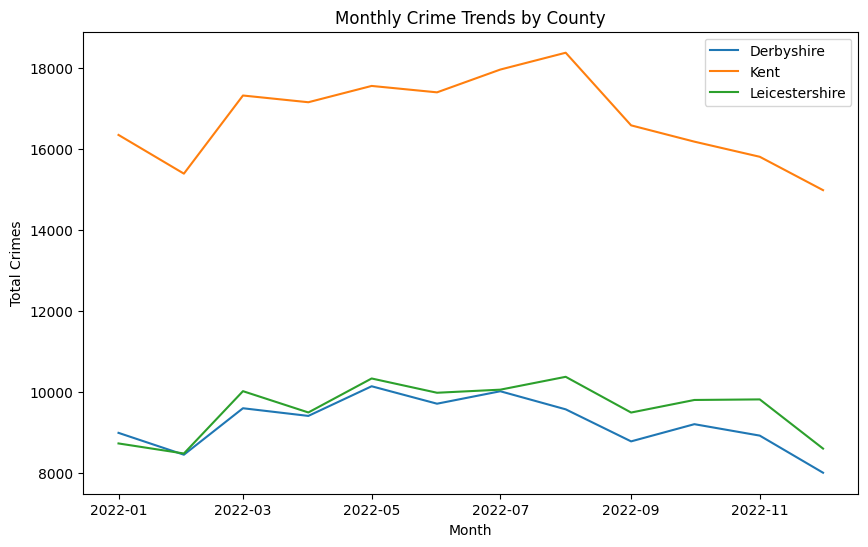

In [16]:
plt.figure(figsize=(10, 6))
for county in monthly_trends_pd["County"].unique():
    county_data = monthly_trends_pd[monthly_trends_pd["County"] == county]
    plt.plot(county_data["Month"], county_data["CrimesInMonth"], label=county)
plt.legend()
plt.title("Monthly Crime Trends by County")
plt.xlabel("Month")
plt.ylabel("Total Crimes")
plt.show()

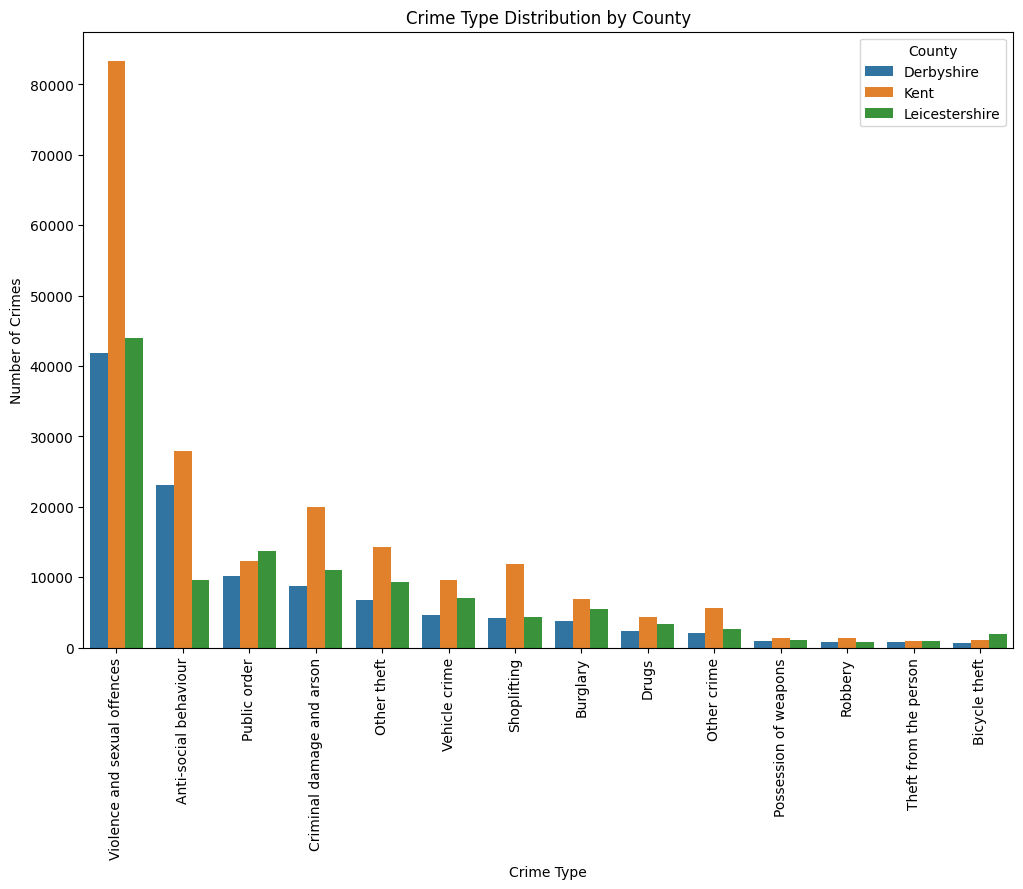

In [17]:
plt.figure(figsize=(12, 8))
sns.barplot(data=crime_type_analysis_pd, x="CrimeType", y="CrimeCount", hue="County")
plt.title("Crime Type Distribution by County")
plt.xticks(rotation=90)
plt.xlabel("Crime Type")
plt.ylabel("Number of Crimes")
plt.show()

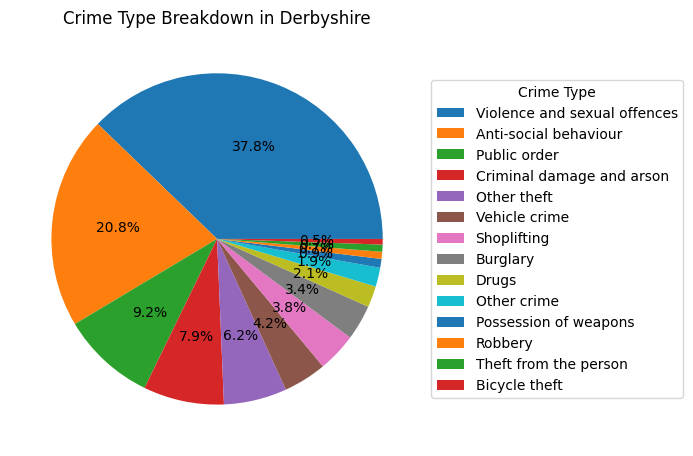

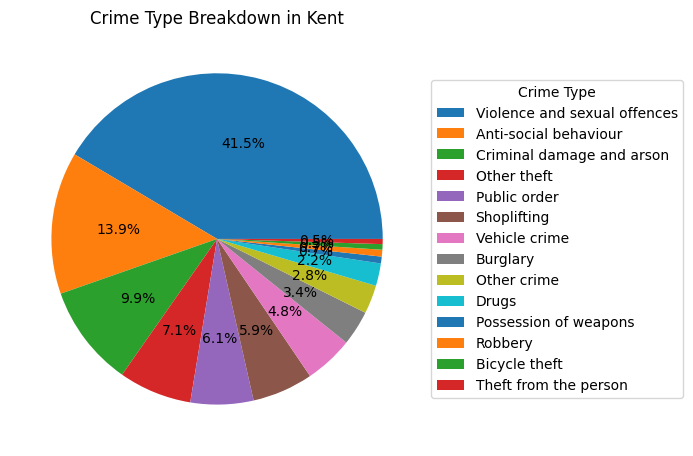

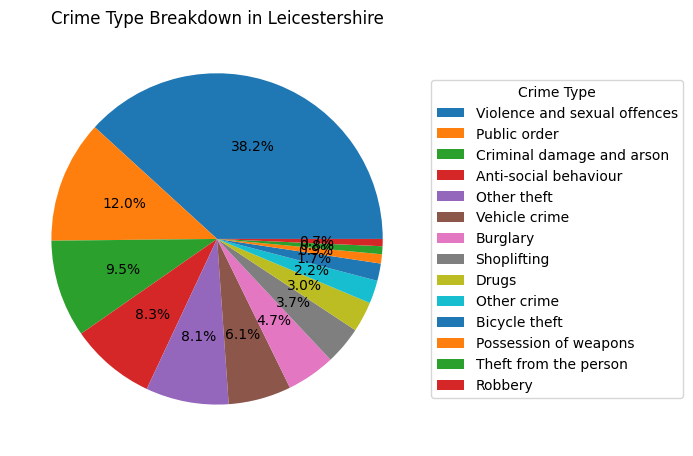

In [18]:
for county in crime_type_analysis_pd["County"].unique():
    county_data = crime_type_analysis_pd[crime_type_analysis_pd["County"] == county]
    
    plt.figure()
    plt.pie(
        county_data["CrimeCount"],
        labels=None,  # Remove labels from the pie chart itself
        autopct="%1.1f%%"  # Show percentages on the pie chart
    )
    
    # Add a legend with crime types
    plt.legend(county_data["CrimeType"], title="Crime Type", bbox_to_anchor=(1, 0.5), loc="center left")
    
    plt.title(f"Crime Type Breakdown in {county}")
    plt.tight_layout()  # Adjust layout to accommodate the legend box
    plt.show()

The combination of monthly trends, crime type distributions, and county-specific profiles provides valuable insights into both the seasonality and types of crimes most prevalent in each region. These insights are critical for authorities to allocate resources effectively, design targeted interventions, and ultimately improve public safety in line with the specific needs of each community.

**PART B**

In [19]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [20]:
import pandas as pd

# Load datasets
train = pd.read_csv('/kaggle/input/loan-prediction-dataset/train_loan.csv')
test = pd.read_csv('/kaggle/input/loan-prediction-dataset/test_loan.csv')

# Check for missing values
print("Missing values in train dataset:\n", train.isnull().sum())
print("Missing values in test dataset:\n", test.isnull().sum())

Missing values in train dataset:
 Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64
Missing values in test dataset:
 Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64


In [21]:
# Fill numerical columns with median values
train['LoanAmount'] = train['LoanAmount'].fillna(train['LoanAmount'].median())
train['Loan_Amount_Term'] = train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].median())
train['Credit_History'] = train['Credit_History'].fillna(train['Credit_History'].mode()[0])

# For categorical columns, fill missing values with the mode (most frequent value)
train['Gender'] = train['Gender'].fillna(train['Gender'].mode()[0])
train['Married'] = train['Married'].fillna(train['Married'].mode()[0])
train['Dependents'] = train['Dependents'].fillna(train['Dependents'].mode()[0])
train['Self_Employed'] = train['Self_Employed'].fillna(train['Self_Employed'].mode()[0])

# Repeat similar steps for the test dataset
test['LoanAmount'] = test['LoanAmount'].fillna(test['LoanAmount'].median())
test['Loan_Amount_Term'] = test['Loan_Amount_Term'].fillna(test['Loan_Amount_Term'].median())
test['Credit_History'] = test['Credit_History'].fillna(test['Credit_History'].mode()[0])
test['Gender'] = test['Gender'].fillna(test['Gender'].mode()[0])
test['Married'] = test['Married'].fillna(test['Married'].mode()[0])
test['Dependents'] = test['Dependents'].fillna(test['Dependents'].mode()[0])
test['Self_Employed'] = test['Self_Employed'].fillna(test['Self_Employed'].mode()[0])


In [22]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical features in train data
for col in ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

# Convert target variable Loan_Status to 0 and 1
train['Loan_Status'] = train['Loan_Status'].map({'Y': 1, 'N': 0})

In [23]:
from sklearn.model_selection import train_test_split

# Separate features and target variable
X = train.drop(columns=['Loan_ID', 'Loan_Status'])
y = train['Loan_Status']

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
# Check if there are any missing values in the target variable Loan_Status
print("Missing values in Loan_Status:", train['Loan_Status'].isnull().sum())

Missing values in Loan_Status: 0


In [25]:
# Drop rows with missing target values
train = train.dropna(subset=['Loan_Status'])

In [26]:
print("Number of rows after dropping missing target values:", train.shape[0])

Number of rows after dropping missing target values: 614


In [27]:
# Check for missing values in the entire dataset
print("Missing values in each column:\n", train.isnull().sum())

Missing values in each column:
 Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


In [28]:
# Check for missing values in Loan_Status before proceeding
print("Missing values in Loan_Status before dropping:", train['Loan_Status'].isnull().sum())

# Drop rows with missing Loan_Status values if any remain
train = train.dropna(subset=['Loan_Status'])

# Confirm the rows have been dropped
print("Missing values in Loan_Status after dropping:", train['Loan_Status'].isnull().sum())


Missing values in Loan_Status before dropping: 0
Missing values in Loan_Status after dropping: 0


In [29]:
# Check for missing values in y_train
print("Missing values in y_train after split:", y_train.isnull().sum())


Missing values in y_train after split: 0


In [30]:
# Separate features and target variable
X = train.drop(columns=['Loan_ID', 'Loan_Status'])
y = train['Loan_Status']

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Initialize the models
log_reg = LogisticRegression(max_iter=1000)
dt = DecisionTreeClassifier(random_state=42)

# Train Logistic Regression model
log_reg.fit(X_train, y_train)

# Train Decision Tree model
dt.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

In [32]:
from sklearn.linear_model import LogisticRegression

# Increase max_iter to a higher value, e.g., 1000
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Create a pipeline that includes scaling and logistic regression
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [34]:
from sklearn.linear_model import LogisticRegression

# Set max_iter to a higher value, such as 2000 or 5000
log_reg = LogisticRegression(solver='saga', max_iter=2000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=2000, solver='saga')

In [35]:
# Try using 'liblinear' solver
log_reg = LogisticRegression(solver='liblinear', max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [36]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Combine scaling and logistic regression in a pipeline
pipeline = make_pipeline(StandardScaler(), LogisticRegression(solver='saga', max_iter=2000))
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=2000, solver='saga'))])

Evaluation Metrics for Logistic Regression:
Accuracy: 0.7837837837837838
Precision: 0.7564102564102564
Recall: 0.9833333333333333


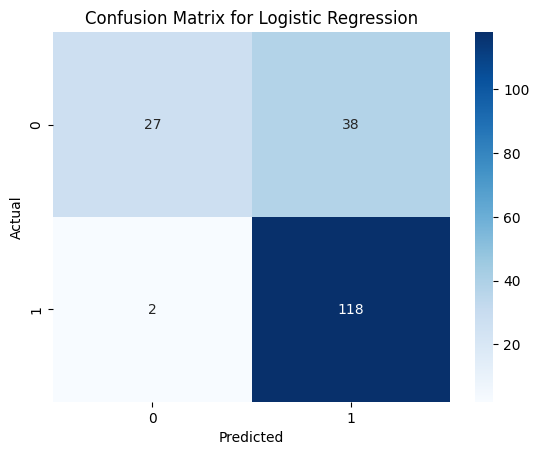

Evaluation Metrics for Decision Tree:
Accuracy: 0.6432432432432432
Precision: 0.717741935483871
Recall: 0.7416666666666667


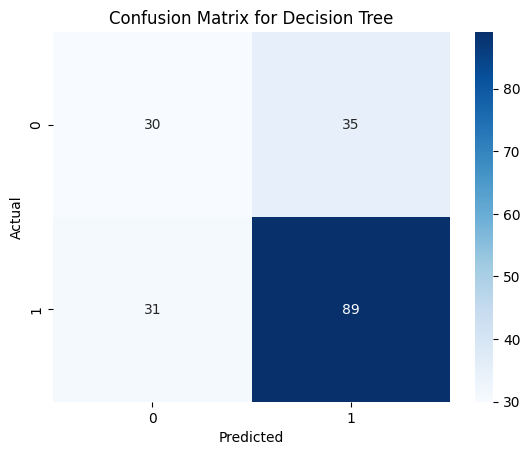

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the validation set
y_pred_log_reg = log_reg.predict(X_val)
y_pred_dt = dt.predict(X_val)

# Define a function to calculate metrics and plot the confusion matrix
def evaluate_model(y_true, y_pred, model_name):
    print(f"Evaluation Metrics for {model_name}:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Evaluate both models
evaluate_model(y_val, y_pred_log_reg, "Logistic Regression")
evaluate_model(y_val, y_pred_dt, "Decision Tree")

In [38]:
# Collect metrics into a dictionary for easy comparison
metrics = {
    "Model": ["Logistic Regression", "Decision Tree"],
    "Accuracy": [
        accuracy_score(y_val, log_reg.predict(X_val)),
        accuracy_score(y_val, dt.predict(X_val))
    ],
    "Precision": [
        precision_score(y_val, log_reg.predict(X_val)),
        precision_score(y_val, dt.predict(X_val))
    ],
    "Recall": [
        recall_score(y_val, log_reg.predict(X_val)),
        recall_score(y_val, dt.predict(X_val))
    ]
}

# Convert to DataFrame for display
metrics_df = pd.DataFrame(metrics)
print(metrics_df)


                 Model  Accuracy  Precision    Recall
0  Logistic Regression  0.783784   0.756410  0.983333
1        Decision Tree  0.643243   0.717742  0.741667
